In [34]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# read in the data using Pandas
data = pd.read_csv('globe_data/bostonglobe2014.csv')

In [36]:
# strip the text of unnecessary whitespaces and removing special characters
def custom_standardization(data):

    spec_chars = ["!",'"',"#","%","&","'","(",")", "*","+",",",
                  "-",".","/",":",";","<", "=",">","?","@","[",
                  "\\","]","^","_", "`","{","|","}","~","–", 
                  "\xc2", "\xa0", "\x80", "\x9c", "\x99", "\x94", 
                  "\xad", "\xe2", "\x9d", "\n"]

    for char in spec_chars:
        data['text'] = data['text'].str.strip()
        data['text'] = data['text'].str.replace(char, ' ')
        
    return data

In [37]:
df = custom_standardization(data)

<ipython-input-36-d04ad14f372a>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['text'] = data['text'].str.replace(char, ' ')


In [38]:
# turn DataFrame into a list of lists of tokens
documents = []
for row in df.values:
    [row] = row
    temp = row.lower().split()
    documents.append(temp)

In [39]:
# create Word2Vec model
model = gensim.models.Word2Vec(window=10, min_count=2, sg=1, workers=10)
model.build_vocab(documents)  # prepare the model vocabulary

In [40]:
# train model on available data
model.train(corpus_iterable=documents, total_examples=len(documents), epochs=5)

(7134625, 9152115)

In [ ]:
# words of interest
# some words are missing in the final 'keywords' list since those do not occur in any of the articles
black_keywords = ['man', 'woman', 'men', 'women', 'male', 'female', 'person', 'people', 'community', 
                  'neighborhood', 'child', 'children', 'kid', 'youth', 'business', 'company']

black_ethnicities = ['black', 'cape verdean', 'afro latino', 'afro latina', 'haitian', 'african american', 
                     'african-american', 'caribbean', 'jamaican', 'dominican', 'west indian']

keywords = ['man', 'woman', 'men', 'women', 'male', 'female', 'person', 'people', 'community', 
            'neighborhood', 'child', 'children', 'kid', 'youth', 'business', 'company',
            'black', 'haitian', 'caribbean', 'jamaican', 'dominican']

In [15]:
# finding similar words and creating a csv file
# code shamelessly copied from Hong

def compute_similar_words(model,source_word, topn=5):
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word, topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words    

def compute_similar_words_for_all_tasks(model, topn=5):
    columns = ['word' + str(i - 1) for i in range(1, topn + 2)]
    df = pd.DataFrame(data=None, columns=columns)
    for source_word in keywords:
        similar_words = compute_similar_words(model, source_word, topn)
        df.loc[len(df)] = similar_words
    for i in range(1, len(similar_words)):
        sec_similar_words = compute_similar_words(model, similar_words[i], topn)
        df.loc[len(df)] = sec_similar_words
    df.to_csv('similar_words_task/similar_words_task_2014.csv')

words = compute_similar_words_for_all_tasks(model)

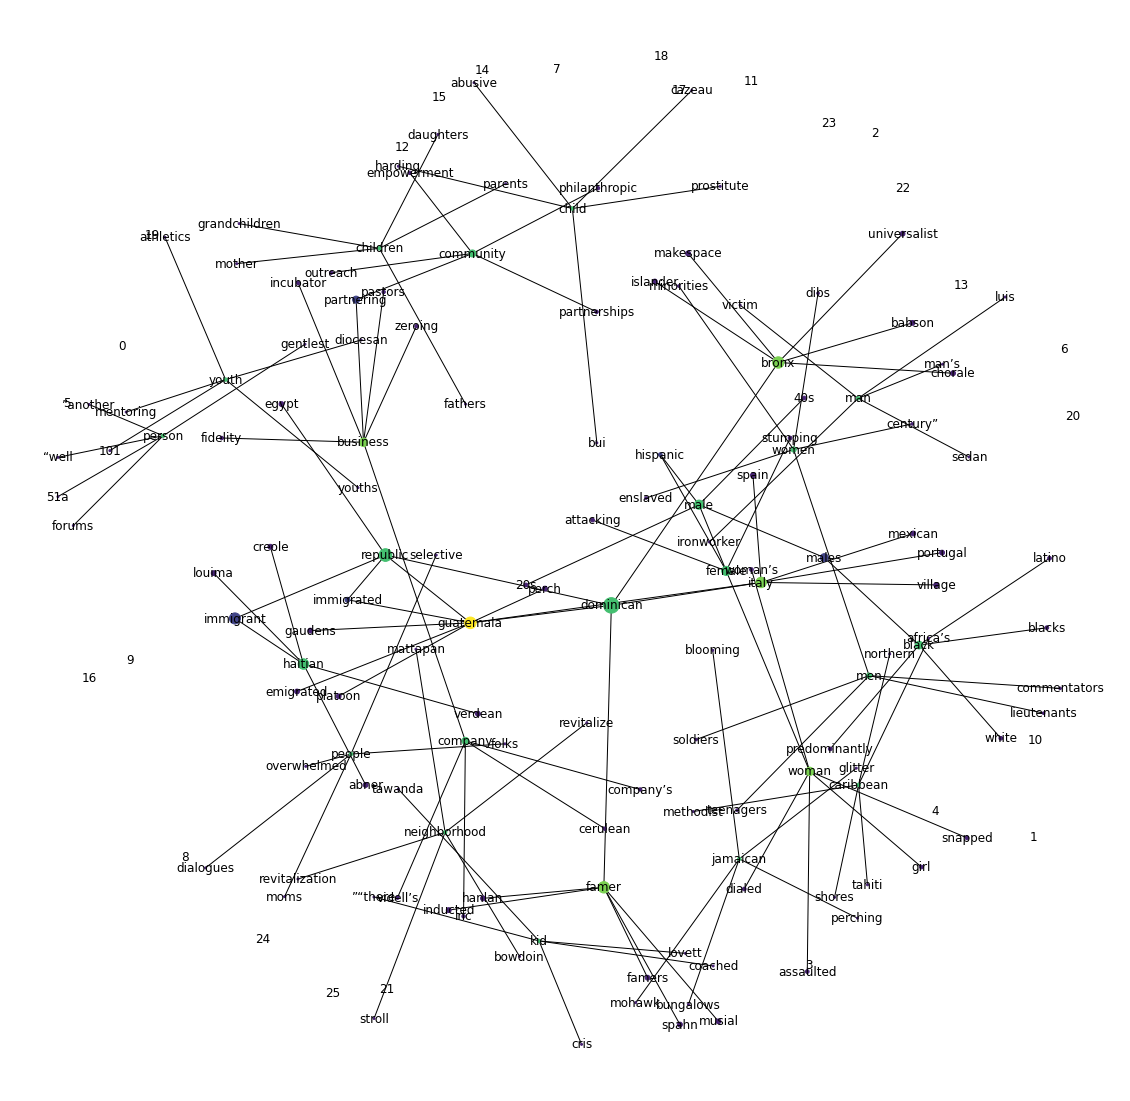

In [16]:
# create word cloud from csv file created using Word2Vec
# code shamelessly copied from Hong

import networkx as nx
from random import randint 
from itertools import count

words = pd.read_csv('similar_words_task/similar_words_task_2014.csv')

G = nx.Graph()
j = 1
for i, row in words.iterrows():
    for j in range(1, len(row)):
        G.add_node(i, label=row[j])
    for j in range(1, len(row)):
        G.add_edge(row[1], row[j])
remove = [node for node, degree in dict(G.degree()).items() if degree > 2]

pos = nx.spring_layout(G, k=0.3)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20, 20))
nx.draw_networkx(G, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size)
plt.axis('off')
plt.savefig('word_clouds/word_cloud_2014.png')
plt.show()